In [12]:
# Librerías que estaremos usando

import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt  
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
import matplotlib.patheffects as path_effects
import matplotlib.font_manager as fm
import matplotlib.patches as patches
from IPython.display import Image 
import scipy.stats as sp 
import os 
from scipy import stats
from scipy.stats import poisson
import seaborn as sns
from pylab import * 
import statsmodels.formula.api as smf
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# Análisis de la Liga Mx 

- Utilizaremos el dataset de Fivethirtyeight para analizar el desempeño de los equipos de la Liga Mx.
    - Si bien este notebook se enfoncará en el Apertura 2022, señalaré los paramétros a modificar para que se pueda analizar cualquier torneo que este entre el Clausura 2017 y el Apertura 2022
- Empezaremos con la tabla general del torneo

In [2]:
# Este es el link donde se encuentra el archivo csv de los partidos de Fútbol

link = 'https://projects.fivethirtyeight.com/soccer-api/club/spi_matches.csv'

df = pd.read_csv(link)


# Creamos un dataframe con los paramétros 

# A diferencia de muchas ligas, en México se juegan dos torneos por año: Apertura y Clasura y, se disputa una fase de playoffs
# Las claves para esos torneos es 1952 para el Aperturaa y 1975 para el Clausura
# Necesitamos también indicar las fechas de inicio y finalización de la fase regular del torneo:
# El campeonato inició el 01 de julio de 2022 y la fase regular terminó el 02 de octubre del mismo año
# Con estos datos iniciemos nuestra 
# si trabajaramos con otra liga que se compite en un año (ya sea natural o ago-may), las fechas serían innecesarias, pues los juegos
# que aún no se han disputado podrian ser eliminados con el comando 'df[df['score1'].isna()==False]'

mex = df[(df.league_id.isin([1952,1975]))&
         (df.date>='2022-07-01')&
         (df.date<='2022-10-02')]

# Ahora en el dataframe "mex" tenemos todos los partidos de fase regular de la liga mx
mex.head(10)

,season,date,league_id,league,team1,team2,spi1,spi2,prob1,prob2,...,importance1,importance2,score1,score2,xg1,xg2,nsxg1,nsxg2,adj_score1,adj_score2
55881,2022,2022-07-01,1952,Mexican Primera Division Torneo Apertura,Mazatlán FC,Puebla,39.60,43.03,0.3966,0.3319,...,29.1,25.7,2.0,4.0,0.54,2.91,1.28,0.98,2.10,4.04
55903,2022,2022-07-02,1952,Mexican Primera Division Torneo Apertura,Guadalajara,FC Juárez,51.37,33.99,0.5990,0.1539,...,21.4,26.9,0.0,0.0,1.85,0.68,1.23,0.40,0.00,0.00
55904,2022,2022-07-02,1952,Mexican Primera Division Torneo Apertura,Necaxa,Toluca,39.86,38.00,0.4480,0.2869,...,27.7,28.2,1.0,3.0,1.34,0.97,1.67,0.42,1.05,3.15
55913,2022,2022-07-02,1952,Mexican Primera Division Torneo Apertura,Tigres UANL,Cruz Azul,62.07,55.30,0.5002,0.2454,...,15.2,11.6,2.0,3.0,2.62,1.91,2.28,0.80,2.10,3.15
55918,2022,2022-07-02,1952,Mexican Primera Division Torneo Apertura,Club América,Atlas,60.32,50.33,0.5290,0.2170,...,15.5,18.3,0.0,0.0,0.94,0.50,1.19,0.73,0.00,0.00
55931,2022,2022-07-03,1952,Mexican Primera Division Torneo Apertura,Pumas Unam,Tijuana,41.31,39.54,0.4480,0.2805,...,29.8,27.5,1.0,1.0,1.27,1.16,2.28,0.42,1.05,1.05
55940,2022,2022-07-03,1952,Mexican Primera Division Torneo Apertura,Atlético San Luis,León,42.10,47.08,0.3857,0.3566,...,26.5,23.1,1.0,2.0,0.80,3.05,1.38,1.79,1.05,2.10
55948,2022,2022-07-03,1952,Mexican Primera Division Torneo Apertura,Santos Laguna,Monterrey,51.84,63.93,0.3098,0.4342,...,16.8,17.2,4.0,3.0,3.55,2.35,1.65,1.23,4.20,3.15
55962,2022,2022-07-04,1952,Mexican Primera Division Torneo Apertura,Pachuca,Querétaro,56.03,37.38,0.6096,0.1601,...,15.9,28.3,2.0,0.0,1.48,1.04,1.30,0.86,2.10,0.00
55980,2022,2022-07-08,1952,Mexican Primera Division Torneo Apertura,Mazatlán FC,Tigres UANL,37.97,61.88,0.2221,0.5470,...,27.2,15.2,0.0,1.0,0.69,1.63,1.19,1.01,0.00,1.05


# Reorganización del dataset

- Podemos observar que los equipos estan organizados por partido, sin embargo esto nos complicaría analizarlos por equipo.
    - Mi solución será hacer un dataframe para los equipos locales y otro para los visitantes y luego unirlos con concat().

- Variables del dataset que consideraremos
    - team1: equipo local
        - En el dataframe "Local", team1 se convertirá en Equipo y team2, Rival
    - team2: equipo visitante
        - En el dataframe "Visita", team2 se convertirá en Equipo y team1, Rival
    - score1: goles anotados por el local
        - En el dataframe "Local", score1 se convertirá en GF (goles a favor)
        - En el dataframe " Visita", score1 se convertirá en GC (goles en contra)
    - score2: goles anotados por el visitante        
        - En el dataframe "Local", score2 se convertirá en GC (goles en contra)
        - En el dataframe " Visita", score2 se convertirá en GF (goles a favor)
    - xg1: probabilidad acumulada que los disparos de el equipo local terminen en gol:
        - En el dataframe "Local", xg1 se convertirá en xGF (goles esperados a favor)
        - En el dataframe " Visia", xg1 se convertirá en xGC (goles esperados en contra)
    - xg2: probabilidad acumulada que los disparos de el equipo visitante terminen en gol:        
        - En el dataframe "Local", xg2 se convertirá en xGC (goles esperados en contra)
        - En el dataframe "Visita", xg2 se convertirá en xGF (goles esperados a favor)
        


In [7]:
# Dataframe locales

local = pd.DataFrame({'Equipo': mex.team1,
                      'Rival': mex.team2,
                      'Fecha': mex.date,
                      'JG': np.where(mex.score1>mex.score2,1,0),
                      'JE': np.where(mex.score1==mex.score2,1,0),
                      'JP': np.where(mex.score1<mex.score2,1,0),
                      'GF': mex.score1,
                      'GC': mex.score2,
                      'Dif': mex.score1-mex.score2,
                      'Pts': np.where(mex.score1>mex.score2,3,np.where(mex.score1<mex.score2,0,1)),
                      'xGF': mex.xg1,
                      'xGC': mex.xg2,
                      'xDif': mex.xg1-mex.xg2}).round(2)

# Dataframe visitantes

visita = pd.DataFrame({'Equipo': mex.team2,
                      'Rival': mex.team1,
                      'Fecha': mex.date,
                      'JG': np.where(mex.score1<mex.score2,1,0),
                      'JE': np.where(mex.score1==mex.score2,1,0),
                      'JP': np.where(mex.score1>mex.score2,1,0),
                      'GF': mex.score2,
                      'GC': mex.score1,
                      'Dif': mex.score2-mex.score1,
                      'Pts': np.where(mex.score1<mex.score2,3,np.where(mex.score1>mex.score2,0,1)),
                      'xGF': mex.xg2,
                      'xGC': mex.xg1,
                      'xDif': mex.xg2-mex.xg1}).round(2)

# Concatenamos ambos dataframes para unirlos

df_mex = pd.concat([local, visita]).sort_values(by='Fecha').reset_index(drop=True)

# Agrupamos por equipo

ap22 = df_mex.groupby('Equipo').sum().sort_values(by='Pts', ascending=False).reset_index()

# Formateamos algunos parametros del output

# Cambiamos para que el indice inicie en 1 y finalice en 18

ap22.index = ap22.index+1

# Quiero que los número enteros de GF y GC no tengan decimales


ap22.GF= ap22.GF.astype(int)
ap22.GC= ap22.GC.astype(int)
ap22.Dif= ap22.Dif.astype(int)

# Output

print("Tabla general del Apertura 2022:")

ap22


Tabla general del Apertura 2022:


,Equipo,JG,JE,JP,GF,GC,Dif,Pts,xGF,xGC,xDif
1,Club América,12,2,3,38,17,21,38,25.71,16.39,9.32
2,Monterrey,10,5,2,29,13,16,35,28.67,15.33,13.34
3,Santos Laguna,10,3,4,38,21,17,33,26.32,27.12,-0.80
4,Pachuca,9,5,3,28,15,13,32,25.11,15.48,9.63
5,Tigres UANL,9,3,5,24,14,10,30,26.57,17.07,9.50
6,Toluca,7,6,4,27,23,4,27,26.40,29.94,-3.54
7,Cruz Azul,7,3,7,26,34,-8,24,21.84,26.26,-4.42
8,Guadalajara,5,7,5,19,17,2,22,24.23,19.47,4.76
9,León,6,4,7,25,29,-4,22,24.02,28.26,-4.24
10,Puebla,4,10,3,25,23,2,22,22.22,20.24,1.98


# Tabla general pt: hacer una tabla más estética

- Lo más importante ya está, pero podemos embellecer la tabla con ayuda de matplotlib

shape= 18 x 11


Text(0.0, 1.0, 'Tabla general, Apertura 2022')

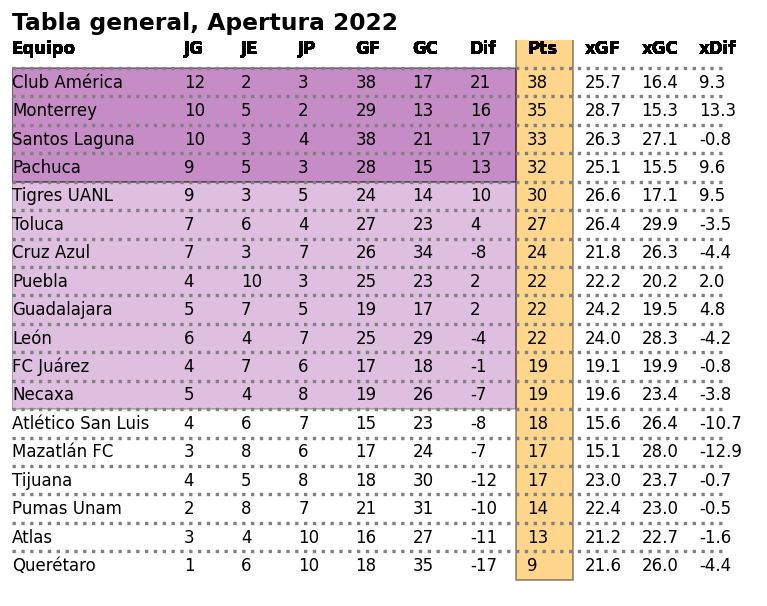

In [16]:
fig, ax = plt.subplots(figsize=(8,6), dpi= 120)

ap22 = ap22.sort_values(by=['Pts', 'Dif', 'GF'])

ap22['xGF'] = round(ap22['xGF'],1)
ap22['xGC'] = round(ap22['xGC'],1)
ap22['xDif'] = round(ap22['xDif'],1)

# Filas que tendrá nuestra tabla
rows = len(ap22)

# Columnas que tendrá nuestra tabla
col = len(ap22.columns)

# Imprimimos la forma de la tabla
print("shape=", rows, "x", col)

# Establecemos el límite del eje y
ax.set_ylim(-1, rows+0.5)

# Establecemos el límite del eje x
ax.set_xlim(-1, col+1)

# Usaremos un loop para introducir los nombres de los equipos y su información como si fueran coordenadas de un diagrama de dispersión

for row in range(rows):
    #Creamos un nuevo dataframe donde se ejecutará el loop
    d= ap22.iloc[row]
    #Introducimos variables por fila
    ax.text(-1, row, s=d['Equipo'], va='center', ha='left')
    ax.text(2, row, s=d['JG'], va='center', ha='left')
    ax.text(3, row, s=d['JE'], va='center', ha='left')
    ax.text(4, row, s=d['JP'], va='center', ha='left')
    ax.text(5, row, s=d['GF'], va='center', ha='left')
    ax.text(6, row, s=d['GC'], va='center', ha='left')
    ax.text(7, row, s=d['Dif'], va='center', ha='left')
    ax.text(8, row, s=d['Pts'], va='center', ha='left')
    ax.text(9, row, s=d['xGF'], va='center', ha='left')
    ax.text(10, row, s=d['xGC'], va='center', ha='left')
    ax.text(11, row, s=d['xDif'], va='center', ha='left')
    #Introducimos títulos de variables
    ax.text(-1,rows, 'Equipo', weight='bold', ha='left')
    ax.text(2,rows, 'JG', weight='bold', ha='left')
    ax.text(3,rows, 'JE', weight='bold', ha='left')
    ax.text(4,rows, 'JP', weight='bold', ha='left')
    ax.text(5,rows, 'GF', weight='bold', ha='left')
    ax.text(6,rows, 'GC', weight='bold', ha='left')
    ax.text(7,rows, 'Dif', weight='bold', ha='left')
    ax.text(8,rows, 'Pts', weight='bold', ha='left')
    ax.text(9,rows, 'xGF', weight='bold', ha='left')
    ax.text(10,rows, 'xGC', weight='bold', ha='left')
    ax.text(11,rows, 'xDif', weight='bold', ha='left')

# Separemos las filas para mejor visibilidad 

for row in range(rows):
    ax.plot(
    [-1,col+0.5],
    [row+.5,row+.5],
    ls=':',
    lw=2,
    c='grey'
    )
    
# Parche para indicar la columna por el cual estan ordenados los equipos, en este caso Puntos obtenidos ("Pts")
    
rect = patches.Rectangle(
    (7.8,-0.5), #coordenadas
    1, #grosor
    (rows+2), #altura
    ec='black',
    fc='orange',
    alpha=0.45,
    zorder=-1
)

ax.add_patch(rect)

# Parche para indicar los equipos que accedieron directo a la fase de cuartos de final


rect1 = patches.Rectangle(
    (-1, 13.5), #coordenadas
    8.8, #grosor
    4, #altura
    ec='black',
    fc='purple',
    alpha=0.45,
    zorder=-1
)

ax.add_patch(rect1)

# Parche para indicar a lo equipos que accedieron a la fase del repechaje


rect2 = patches.Rectangle(
    (-1,5.5), #coordenadas
    8.8, #grosor
    8, #altura
    ec='black',
    fc='purple',
    alpha=0.25,
    zorder=-1
)

ax.add_patch(rect2)

# Eliminamos los ejes

ax.axis('off')

# Título de la grafica

ax.set_title(
'Tabla general, Apertura 2022',
    loc='left',
    fontsize=14,
    weight='bold'
)

